# Extract data from invitrodb 

In [1]:
from sqlalchemy import create_engine, inspect, text
import polars as pl
import gc

In [ ]:
# 'intended target family' would be a cool way to subset the cell-free assay types
# cell-free assays don't have paired viability assays (doesn't make sense for cellfree)
# use "cell_viability_assay", not "burst_assay" because burst_assay misses some
# Level 4 has the min / max concentration, plus number of concentrations tested

# 1:1 relationship between components and endpoints (yay)
# DECISION: treat bidirectional assays the same, with the motivation from MorphMap that knock-down/overexpression phenotypes are positively correlated


## Get assay and endpoint information

In [327]:
# Get assays of interest
engine = create_engine("mysql+pymysql://root@localhost/prod_internal_invitrodb_v4_1")

with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM assay"))
    column_names = result.keys()
    rows = result.fetchall()
    rows = [list(row) for row in rows]
    assay = pl.DataFrame(rows, schema=column_names)

print(assay.shape)

assay = assay.filter(pl.col("cell_format") != "whole embryo")
assay = assay.filter(pl.col("organism") == "human")
cell_assay = assay.filter(pl.col("cell_format").is_in(["cell-based", "cell line", "primary cell", "secondary cell", "primary cell co-culture"]))
cellfree_assay = assay.filter(pl.col("cell_format").is_in(["tissue-based cell-free", "cell-free"]))

# remove follow-up experiments
cellfree_assay = cellfree_assay.filter(~pl.col("assay_name").str.contains("Followup"))
cell_assay = cell_assay.filter(~pl.col("assay_name").str.contains("Followup"))
cell_assay = cell_assay.filter(~pl.col("assay_name").str.contains("TRANS"))
cell_assay = cell_assay.filter(~pl.col("assay_name").str.contains("EcoTox"))

cell_assay = cell_assay.filter(~pl.col("assay_name").is_in([
    "CLD_6hr", "CLD_24hr", "APR_HepG2_1hr", "APR_HepG2_72hr"]
    ))

# get aid lists
cell_aid = cell_assay.select("aid").to_series().unique().to_list()
cellfree_aid = cellfree_assay.select("aid").to_series().unique().to_list()

assay_keep = ["aid", "timepoint_hr", "cell_format", "tissue", "cell_short_name"]
cell_assay = cell_assay.select(assay_keep)
cellfree_assay = cellfree_assay.select(assay_keep)

(623, 18)


In [328]:
# Get assay components of interest
engine = create_engine("mysql+pymysql://root@localhost/prod_internal_invitrodb_v4_1")

with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM assay_component"))
    column_names = result.keys()
    rows = result.fetchall()
    rows = [list(row) for row in rows]
    component = pl.DataFrame(rows, schema=column_names).drop([
        "detection_technology_type", "detection_technology_type_sub", "detection_technology", 
        "key_assay_reagent_type", "key_assay_reagent", "technological_target_type", "technological_target_type_sub",
        "parameter_readout_type", "assay_component_target_desc", "assay_design_type_sub", "biological_process_target"
    ])

component = component.filter(~pl.col("assay_component_name").str.contains("_ch1"))
component = component.filter(~pl.col("assay_component_name").str.contains("_ch2"))
component = component.filter(~pl.col("assay_component_name").is_in([
    "TOX21_RT_HEPG2_FLO_00hr_viability",
    "TOX21_RT_HEPG2_FLO_08hr_viability",
    "TOX21_RT_HEPG2_FLO_16hr_viability",
    "TOX21_RT_HEPG2_FLO_24hr_viability",
    "TOX21_RT_HEPG2_FLO_32hr_viability",
    "TOX21_RT_HEPG2_GLO_00hr_viability",
    "TOX21_RT_HEPG2_GLO_08hr_viability",
    "TOX21_RT_HEPG2_GLO_16hr_viability",
    "TOX21_RT_HEPG2_GLO_24hr_viability",
    "TOX21_RT_HEPG2_GLO_32hr_viability",
    "TOX21_RT_HEK293_FLO_00hr_viability",
    "TOX21_RT_HEK293_FLO_08hr_viability",
    "TOX21_RT_HEK293_FLO_16hr_viability",
    "TOX21_RT_HEK293_FLO_24hr_viability",
    "TOX21_RT_HEK293_FLO_32hr_viability",
    "TOX21_RT_HEK293_GLO_00hr_viability",
    "TOX21_RT_HEK293_GLO_08hr_viability",
    "TOX21_RT_HEK293_GLO_16hr_viability",
    "TOX21_RT_HEK293_GLO_24hr_viability",
    "TOX21_RT_HEK293_GLO_32hr_viability",
]))
component = component.drop("assay_component_name")


cell_component = component.filter(pl.col("aid").is_in(cell_aid))
cell_component = cell_component.filter(pl.col("assay_design_type") != "background reporter")

# there is only one component per assay for the cell-free assays
cellfree_component = component.filter(pl.col("aid").is_in(cellfree_aid))

cell_acid = cell_component.select("acid").to_series().unique().to_list()
cellfree_acid = cellfree_component.select("acid").to_series().unique().to_list()


In [329]:
# Get assay endpoints of interest
engine = create_engine("mysql+pymysql://root@localhost/prod_internal_invitrodb_v4_1")

with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM assay_component_endpoint"))
    column_names = result.keys()
    rows = result.fetchall()
    rows = [list(row) for row in rows]
    endpoints = pl.DataFrame(rows, schema=column_names).drop([
        "export_ready", "internal_ready", "fit_all", "data_usability", "burst_assay", "key_positive_control",
        "assay_component_endpoint_desc"
    ])

endpoints = endpoints.filter(pl.col("assay_function_type") != "background control")
cell_endpoints = endpoints.filter(pl.col("acid").is_in(cell_acid))
cellfree_endpoints = endpoints.filter(pl.col("acid").is_in(cellfree_acid))

In [330]:
# join and re-order columns
col_order = [
    "assay_component_endpoint_name", "assay_component_desc",
    "cell_format", "tissue", "cell_short_name", "timepoint_hr",
    "assay_design_type", "assay_function_type", "intended_target_type", "intended_target_type_sub",
    "intended_target_family", "intended_target_family_sub", "normalized_data_type", "signal_direction",
    "cell_viability_assay", "aid", "acid", "aeid",
]

cell = cell_component.join(cell_endpoints, on="acid")
cell = cell.join(cell_assay, on="aid").select(col_order)

# separate primary endpoint from viability assays
cell_viability = cell.filter(pl.col("cell_viability_assay") == 1)
cell_other = cell.filter(pl.col("cell_viability_assay") == 0).filter(pl.col("cell_short_name") != "NA")

cellfree = cellfree_component.join(cellfree_endpoints, on="acid")
cellfree = cellfree.join(cellfree_assay, on="aid").select(col_order)

## Get assay hitcall info

In [331]:
# Get level 4 data
with engine.connect() as connection:
    result = connection.execute(text("SELECT `m4id`, `spid`, `logc_max`, `logc_min`, `nconc` FROM mc4"))
    column_names = result.keys()
    rows = result.fetchall()
    rows = [list(row) for row in rows]
    exp_info = pl.DataFrame(rows, schema=column_names)

    result = connection.execute(text("SELECT * FROM sample"))
    column_names = result.keys()
    rows = result.fetchall()
    rows = [list(row) for row in rows]
    dat = pl.DataFrame(rows, schema=column_names).select(["spid", "chid"])

exp_info = exp_info.join(dat, on="spid")
del dat
gc.collect()

0

In [332]:
# Link m5id to m4id
with engine.connect() as connection:
    result = connection.execute(text("SELECT `m5id`, `m4id` FROM mc5"))
    
    column_names = result.keys()
    rows = result.fetchall()
    rows = [list(row) for row in rows]
    m4_m5 = pl.DataFrame(rows, schema=column_names)

exp_info = exp_info.join(m4_m5, on="m4id")
del m4_m5
gc.collect()

0

In [333]:
# Get hitcall and AC50
m5id_list = exp_info.select("m5id").to_series().unique().to_list()

query = """
SELECT `m5id`, `hit_val`, `hit_param`, `aeid`
FROM mc5_param 
WHERE hit_param IN ('ac50', 'hitcall') 
AND m5id IN :m5ids
"""

with engine.connect() as connection:
    result = connection.execute(text(query), {"m5ids": tuple(m5id_list)})
    
    column_names = result.keys()
    rows = result.fetchall()
    rows = [list(row) for row in rows]
    params = pl.DataFrame(rows, schema=column_names)

params = params.pivot(
    values="hit_val",
    index=["m5id", "aeid"],
    columns="hit_param"
)

exp_info = exp_info.join(params, on="m5id")
del params
gc.collect()

0

In [334]:
# Make table for compounds
engine = create_engine("mysql+pymysql://root@localhost/prod_internal_invitrodb_v4_1")

with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM chemical"))
    column_names = result.keys()
    rows = result.fetchall()
    rows = [list(row) for row in rows]
    chemical = pl.DataFrame(rows, schema=column_names).select(["chid", "dsstox_substance_id"])

exp_info = exp_info.join(chemical, on="chid")


## Get a cytotox estimate for each chemical + relevant assay 

We only want to keep assays with matching cytotoxicity estimates. We consider a matching cytotox estimate as a viability assay run with the same chemical in either the same cell line or the same tissue. We count any cytotox hit as a hit - it's possible that viability assays that did not result in a hit tested lower concentration ranges, or a less sensitive viability assay.

In [335]:
df = cell_viability.select(["aeid", "aid", "cell_viability_assay", "cell_short_name", "tissue"])
df = df.join(exp_info, on="aeid")

df = df.with_columns(
    (pl.col("hitcall") > 0.9).cast(pl.Int64).alias("hitcall")
)

result_cell = (
    df.group_by(["chid", "cell_short_name"])
    .agg([
        pl.count().alias("ntested"),
        pl.col("hitcall").sum().alias("nhit"),
        pl.col("ac50").filter(pl.col("hitcall") == 1).median().alias("cytotox_median_ac50")
    ])
)

result_tissue = (
    df.group_by(["tissue", "chid"])
    .agg([
        pl.count().alias("ntested"),
        pl.col("hitcall").sum().alias("nhit"),
        pl.col("ac50").filter(pl.col("hitcall") == 1).median().alias("cytotox_median_ac50")
    ])
)


In [336]:
cell_chid_cytotox = cell_results.select(["chid", "cell_short_name", "tissue"]).unique()

cell_cytotox = cell_chid_cytotox.join(
    result_cell,
    on=["chid", "cell_short_name"],
    how="inner"
).with_columns(
    pl.lit("cell_short_name").alias("cytotox_source")
)

unmatched_df = cell_chid_cytotox.join(
    result_cell,
    on=["chid", "cell_short_name"],
    how="anti"
)

tissue_cytotox = unmatched_df.join(
    result_tissue,
    on=["chid", "tissue"],
    how="inner"
).with_columns(
    pl.lit("tissue").alias("cytotox_source")
)

cytotox = pl.concat([cell_cytotox, tissue_cytotox], how="vertical").rename({"ntested": "cytotox_ntested", "nhit": "cytotox_nhit"})

## Create final results info files

In [337]:
# Get OASIS IDs
oasis = pl.read_csv("../1_snakemake/inputs/annotations/seal_input/v5_oasis_03Sept2024_simple.csv")
oasis = oasis.select(["OASIS_ID", "DTXSID"]).rename({"DTXSID": "dsstox_substance_id"})

In [338]:
# cell-free assays
cellfree_results = exp_info.join(cellfree, on="aeid")

# add oasis id
cellfree_results = cellfree_results.join(oasis, on="dsstox_substance_id")

# re-order columns
cellfree_results = cellfree_results.select([
    "OASIS_ID",
    "assay_component_endpoint_name", "assay_component_desc",
    "cell_format", "tissue", "cell_short_name", "timepoint_hr",
    "assay_design_type", "assay_function_type", "intended_target_type", "intended_target_type_sub",
    "intended_target_family", "intended_target_family_sub", "normalized_data_type", "signal_direction",
    "hitcall", "ac50",
    "logc_max", "logc_min", "nconc",
    "aid", "acid", "aeid", "chid", "m4id", "m5id", "dsstox_substance_id"
])

In [339]:
# cell-based assays
cell_results = exp_info.join(cell_other, on="aeid")

# add oasis id
cell_results = cell_results.join(oasis, on="dsstox_substance_id")

# Merge assay info with cytotox estimates
cell_results = cell_results.join(cytotox, on=["chid", "cell_short_name", "tissue"])

# Re-order columns
cell_results = cell_results.select([
    "OASIS_ID",
    "assay_component_endpoint_name", "assay_component_desc",
    "cell_format", "tissue", "cell_short_name", "timepoint_hr",
    "assay_design_type", "assay_function_type", "intended_target_type", "intended_target_type_sub",
    "intended_target_family", "intended_target_family_sub", "normalized_data_type", "signal_direction",
    "hitcall", "ac50",
    "cytotox_ntested", "cytotox_nhit", "cytotox_median_ac50", "cytotox_source",
    "logc_max", "logc_min", "nconc",
    "aid", "acid", "aeid", "chid", "m4id", "m5id", "dsstox_substance_id"
])

## Create binary cell-based hit file

In [340]:
# Hit: must be 2-fold lower than the cytotox ac50
cell_binary = cell_results.select([
    "OASIS_ID", "assay_component_endpoint_name", "hitcall", "ac50", "cytotox_median_ac50"
]).with_columns(
    (pl.col("hitcall") > 0.9).cast(pl.Int64).alias("hitcall"),
    (pl.col("cytotox_median_ac50")).fill_null(999999).alias("cytotox_median_ac50")
)

cell_binary = cell_binary.with_columns(
    pl.when((pl.col("cytotox_median_ac50")/2) < pl.col("ac50"))
    .then(pl.lit(0))
    .otherwise(pl.col("hitcall"))
    .alias("corr_hitcall")
)

# Sometimes there are multiple results for the same chemical-assay combo. Use majority hitcall as the hitcall. Ties go to no hit.
aggregated_df = (
    cell_binary.group_by(["OASIS_ID", "assay_component_endpoint_name"])
    .agg([
        (
            (pl.col("corr_hitcall").sum() > (pl.count() // 2))
            .cast(pl.Int64)
            .alias("corr_hitcall")
        )
    ])
)
cell_binary = cell_binary.select(["OASIS_ID", "assay_component_endpoint_name"]).unique()
cell_binary = cell_binary.join(aggregated_df, on=["OASIS_ID", "assay_component_endpoint_name"])

# pivot to one column per assay
cell_binary = cell_binary.pivot(
    values="corr_hitcall",
    index="OASIS_ID",
    columns="assay_component_endpoint_name",
)

# only keep assays with at least 5 positive and 5 negative classes
def has_min_zeros_and_ones(col):
    return (col == 0).sum() >= 5 and (col == 1).sum() >= 5

cell_binary = cell_binary.select(
    ["OASIS_ID"] + [
        col for col in cell_binary.columns if col != "OASIS_ID" and has_min_zeros_and_ones(cell_binary[col])
    ]
)

cell_assays = [i for i in cell_binary.columns if "OASIS_ID" not in i]

## Create binary cell-free hit file

In [341]:
cellfree_binary = cellfree_results.with_columns(
    (pl.col("hitcall") > 0.9).cast(pl.Int64).alias("hitcall")
).select(["OASIS_ID", "assay_component_endpoint_name", "hitcall"])

# Sometimes there are multiple results for the same chemical-assay combo. Use majority hitcall as the hitcall. Ties go to no hit.
aggregated_df = (
    cellfree_binary.group_by(["OASIS_ID", "assay_component_endpoint_name"])
    .agg([
        (
            (pl.col("hitcall").sum() > (pl.count() // 2))
            .cast(pl.Int64)
            .alias("hitcall")
        )
    ])
)
cellfree_binary = cellfree_binary.drop(["hitcall"]).unique()
cellfree_binary = cellfree_binary.join(aggregated_df, on=["OASIS_ID", "assay_component_endpoint_name"])

# pivot to one column per assay
cellfree_binary = cellfree_binary.pivot(
    values="hitcall",
    index="OASIS_ID",
    columns="assay_component_endpoint_name",
)

# only keep assays with at least 5 positive and 5 negative classes
def has_min_zeros_and_ones(col):
    return (col == 0).sum() >= 5 and (col == 1).sum() >= 5

cellfree_binary = cellfree_binary.select(
    ["OASIS_ID"] + [
        col for col in cellfree_binary.columns if col != "OASIS_ID" and has_min_zeros_and_ones(cellfree_binary[col])
    ]
)

cellfree_assays = [i for i in cellfree_binary.columns if "OASIS_ID" not in i]

## Write out all files

In [342]:
cell_binary.write_parquet("../1_snakemake/inputs/annotations/toxcast_cellbased_binary.parquet")
cellfree_binary.write_parquet("../1_snakemake/inputs/annotations/toxcast_cellfree_binary.parquet")

cell_results.filter(pl.col("assay_component_endpoint_name").is_in(cell_assays)).write_parquet("../1_snakemake/inputs/annotations/toxcast_cellbased_info.parquet")
cellfree_results.filter(pl.col("assay_component_endpoint_name").is_in(cellfree_assays)).write_parquet("../1_snakemake/inputs/annotations/toxcast_cellfree_info.parquet")

## Summarize extracted assays

In [3]:
cell_info = pl.read_parquet("../1_snakemake/inputs/annotations/toxcast_cellbased_info.parquet")
cellfree_info = pl.read_parquet("../1_snakemake/inputs/annotations/toxcast_cellfree_info.parquet")

cell_binary = pl.read_parquet("../1_snakemake/inputs/annotations/toxcast_cellbased_binary.parquet")
cellfree_binary = pl.read_parquet("../1_snakemake/inputs/annotations/toxcast_cellfree_binary.parquet")

In [12]:
# Compute stats for cell-based assays
cols = [i for i in cell_binary.columns if "OASIS_ID" not in i]
cell_stats = []
for col in cols:
    pos = cell_binary.filter(pl.col(col) == 1).shape[0]
    neg = cell_binary.filter(pl.col(col) == 0).shape[0]
    total = pos + neg

    cell_stats.append(pl.DataFrame({
        "assay_component_endpoint_name": col,
        "Num_pos": pos,
        "Num_neg": neg,
        "Total": total,
        "Percent_positive": pos/total
    }))

cell_stats = pl.concat(cell_stats)

In [13]:
# Compute stats for cell-free assays
cols = [i for i in cellfree_binary.columns if "OASIS_ID" not in i]
cellfree_stats = []
for col in cols:
    pos = cellfree_binary.filter(pl.col(col) == 1).shape[0]
    neg = cellfree_binary.filter(pl.col(col) == 0).shape[0]
    total = pos + neg

    cellfree_stats.append(pl.DataFrame({
        "assay_component_endpoint_name": col,
        "Num_pos": pos,
        "Num_neg": neg,
        "Total": total,
        "Percent_positive": pos/total
    }))

cellfree_stats = pl.concat(cellfree_stats)

In [ ]:
# plot stats
cell_stats = cell_stats.with_columns(pl.lit("cell_based").alias("assay_type"))
cellfree_stats = cellfree_stats.with_columns(pl.lit("cell_free").alias("assay_type"))

shape: (5, 6)
┌────────────────────────────────┬─────────┬─────────┬───────┬──────────────────┬────────────┐
│ assay_component_endpoint_name  ┆ Num_pos ┆ Num_neg ┆ Total ┆ Percent_positive ┆ assay_type │
│ ---                            ┆ ---     ┆ ---     ┆ ---   ┆ ---              ┆ ---        │
│ str                            ┆ i64     ┆ i64     ┆ i64   ┆ f64              ┆ str        │
╞════════════════════════════════╪═════════╪═════════╪═══════╪══════════════════╪════════════╡
│ ACEA_ER_80hr                   ┆ 38      ┆ 346     ┆ 384   ┆ 0.098958         ┆ cell_based │
│ APR_HepG2_CellCycleArrest_24hr ┆ 10      ┆ 240     ┆ 250   ┆ 0.04             ┆ cell_based │
│ APR_HepG2_CellLoss_24hr        ┆ 20      ┆ 230     ┆ 250   ┆ 0.08             ┆ cell_based │
│ APR_HepG2_MicrotubuleCSK_24hr  ┆ 9       ┆ 241     ┆ 250   ┆ 0.036            ┆ cell_based │
│ APR_HepG2_MitoMass_24hr        ┆ 8       ┆ 242     ┆ 250   ┆ 0.032            ┆ cell_based │
└────────────────────────────────┴──

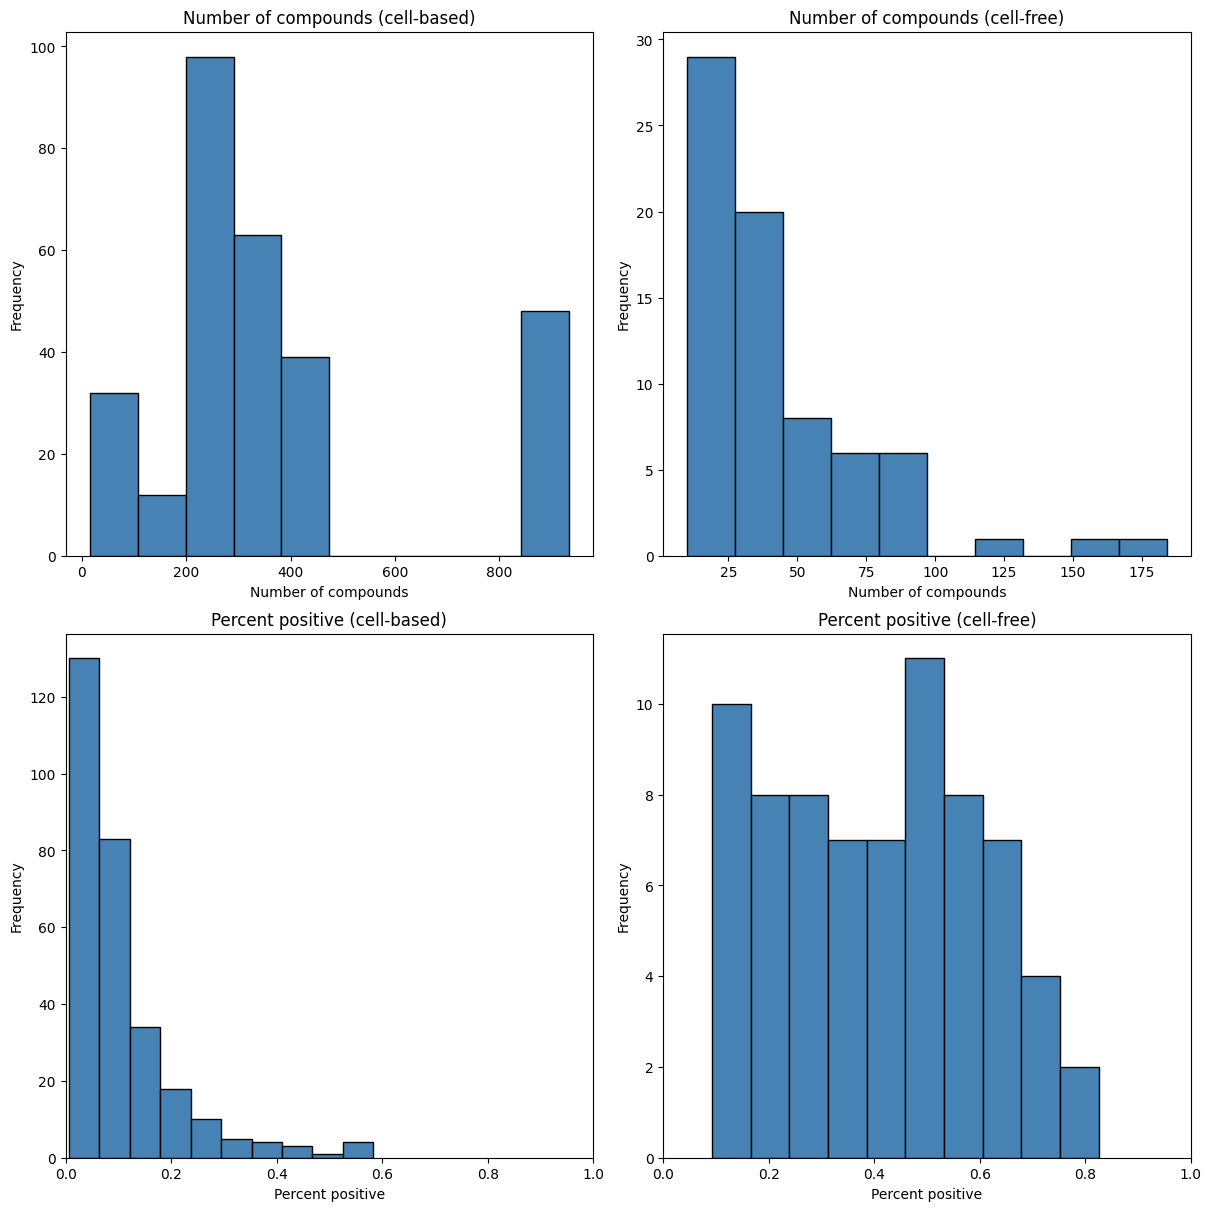

In [48]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 12), constrained_layout=True)

axes[0, 0].hist(cell_stats["Total"], bins=10, color="steelblue", edgecolor="black")
axes[0, 0].set_title("Number of compounds (cell-based)")
axes[0, 0].set_xlabel("Number of compounds")
axes[0, 0].set_ylabel("Frequency")

axes[0, 1].hist(cellfree_stats["Total"], bins=10, color="steelblue", edgecolor="black")
axes[0, 1].set_title("Number of compounds (cell-free)")
axes[0, 1].set_xlabel("Number of compounds")
axes[0, 1].set_ylabel("Frequency")

axes[1, 0].hist(cell_stats["Percent_positive"], bins=10, color="steelblue", edgecolor="black")
axes[1, 0].set_title("Percent positive (cell-based)")
axes[1, 0].set_xlabel("Percent positive")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_xlim(0, 1)

axes[1, 1].hist(cellfree_stats["Percent_positive"], bins=10, color="steelblue", edgecolor="black")
axes[1, 1].set_title("Percent positive (cell-free)")
axes[1, 1].set_xlabel("Percent positive")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_xlim(0, 1)

plt.show()

In [53]:
print(f"Median % positive in cell-based: {str(cell_stats.select(pl.col('Percent_positive').median()).item())}")
print(f"Median % positive in cell-free: {str(cellfree_stats.select(pl.col('Percent_positive').median()).item())}")

print(f"Median cmpd # in cell-based: {str(cell_stats.select(pl.col('Total').median()).item())}")
print(f"Median cmpd # in cell-free: {str(cellfree_stats.select(pl.col('Total').median()).item())}")

Median % positive in cell-based: 0.071161355334425
Median % positive in cell-free: 0.4134295227524972
Median cmpd # in cell-based: 306.0
Median cmpd # in cell-free: 33.0


In [15]:
cellfree_info = cellfree_info.select([
    "assay_component_endpoint_name",
    "assay_function_type",
    "intended_target_family",
    "intended_target_family_sub"
]).unique().filter(
    pl.col("assay_component_endpoint_name").is_in(cellfree_stats.select("assay_component_endpoint_name").to_series().to_list())
)

In [16]:
cell_info = cell_info.select([
    "assay_component_endpoint_name",
    "tissue",
    "cell_short_name",
    "intended_target_type",
    "intended_target_family",
    "intended_target_family_sub"
]).unique().filter(
    pl.col("assay_component_endpoint_name").is_in(cell_stats.select("assay_component_endpoint_name").to_series().to_list())
)

### Print out summaries of cell-based assays

In [18]:
print(f"Cell-free assays: {str(cellfree_info.shape[0])}")
print(f"Cell-based assays: {str(cell_info.shape[0])}")

Cell-free assays: 72
Cell-based assays: 292


In [ ]:
tissue = cell_info.select(pl.col("tissue").value_counts()).unnest("tissue").sort("count", descending=True)
print(f"Unique tissues in cell-based assays: {str(tissue.shape[0])}")
tissue = tissue.with_columns(
    (pl.col("count")/cell_info.shape[0]).alias("percent")
)
tissue

Unique tissues in cell-based assays: 14


tissue,count,percent
str,u32,f64
"""liver""",151,0.517123
"""vascular""",63,0.215753
"""kidney""",35,0.119863
"""adrenal gland""",12,0.041096
"""breast""",9,0.030822
"""cervix""",7,0.023973
"""intestinal""",5,0.017123
"""brain""",2,0.006849
"""mammary gland/…",2,0.006849


In [30]:
celltypes = cell_info.select(pl.col("cell_short_name").value_counts()).unnest("cell_short_name").sort("count", descending=True)
print(f"Unique cell types in cell-based assays: {str(celltypes.shape[0])}")
celltypes = celltypes.with_columns(
    (pl.col("count")/cell_info.shape[0]).alias("percent")
)
celltypes

Unique cell types in cell-based assays: 27


cell_short_name,count,percent
str,u32,f64
"""HepaRG""",90,0.308219
"""HepG2""",54,0.184932
"""HEK293T""",28,0.09589
"""umbilical vein…",20,0.068493
"""umbilical vein…",17,0.058219
"""coronary arter…",12,0.041096
"""H295R""",12,0.041096
"""B and peripher…",7,0.023973
"""lung fibroblas…",7,0.023973


In [ ]:
target_type = cell_info.select(pl.col("intended_target_type").value_counts()).unnest("intended_target_type").sort("count", descending=True)
print(f"Unique target types in cell-based assays: {str(target_type.shape[0])}")
target_type = target_type.with_columns(
    (pl.col("count")/cell_info.shape[0]).alias("percent")
)
print(target_type)

Unique target types in cell-based assays: 6
shape: (6, 3)
┌──────────────────────┬───────┬──────────┐
│ intended_target_type ┆ count ┆ percent  │
│ ---                  ┆ ---   ┆ ---      │
│ str                  ┆ u32   ┆ f64      │
╞══════════════════════╪═══════╪══════════╡
│ protein              ┆ 135   ┆ 0.462329 │
│ rna                  ┆ 96    ┆ 0.328767 │
│ pathway              ┆ 33    ┆ 0.113014 │
│ cellular             ┆ 15    ┆ 0.05137  │
│ molecular messenger  ┆ 12    ┆ 0.041096 │
│ dna                  ┆ 1     ┆ 0.003425 │
└──────────────────────┴───────┴──────────┘


In [34]:
target_family = cell_info.select(pl.col("intended_target_family").value_counts()).unnest("intended_target_family").sort("count", descending=True)
print(f"Unique target families in cell-based assays: {str(target_family.shape[0])}")
target_family = target_family.with_columns(
    (pl.col("count")/cell_info.shape[0]).alias("percent")
)
print(target_family)

Unique target families in cell-based assays: 36
shape: (36, 3)
┌────────────────────────┬───────┬──────────┐
│ intended_target_family ┆ count ┆ percent  │
│ ---                    ┆ ---   ┆ ---      │
│ str                    ┆ u32   ┆ f64      │
╞════════════════════════╪═══════╪══════════╡
│ nuclear receptor       ┆ 56    ┆ 0.191781 │
│ dna binding            ┆ 54    ┆ 0.184932 │
│ cytokine               ┆ 32    ┆ 0.109589 │
│ cyp                    ┆ 18    ┆ 0.061644 │
│ …                      ┆ …     ┆ …        │
│ immunoglobulin         ┆ 1     ┆ 0.003425 │
│ catalase               ┆ 1     ┆ 0.003425 │
│ transcription factor   ┆ 1     ┆ 0.003425 │
│ microrna               ┆ 1     ┆ 0.003425 │
└────────────────────────┴───────┴──────────┘


### Print out summaries of cell-free assays

In [37]:
target_family = cellfree_info.select(pl.col("intended_target_family").value_counts()).unnest("intended_target_family").sort("count", descending=True)
print(f"Unique target families in cell-free assays: {str(target_family.shape[0])}")
target_family = target_family.with_columns(
    (pl.col("count")/cellfree_info.shape[0]).alias("percent")
)
print(target_family)

Unique target families in cell-free assays: 11
shape: (11, 3)
┌────────────────────────┬───────┬──────────┐
│ intended_target_family ┆ count ┆ percent  │
│ ---                    ┆ ---   ┆ ---      │
│ str                    ┆ u32   ┆ f64      │
╞════════════════════════╪═══════╪══════════╡
│ gpcr                   ┆ 21    ┆ 0.291667 │
│ cyp                    ┆ 11    ┆ 0.152778 │
│ nuclear receptor       ┆ 10    ┆ 0.138889 │
│ protease               ┆ 7     ┆ 0.097222 │
│ …                      ┆ …     ┆ …        │
│ phosphatase            ┆ 3     ┆ 0.041667 │
│ hydrolase              ┆ 2     ┆ 0.027778 │
│ dehalogenase           ┆ 1     ┆ 0.013889 │
│ ion channel            ┆ 1     ┆ 0.013889 │
└────────────────────────┴───────┴──────────┘


In [38]:
assay_function_type = cellfree_info.select(pl.col("assay_function_type").value_counts()).unnest("assay_function_type").sort("count", descending=True)
print(f"Unique assay_function_type in cell-free assays: {str(assay_function_type.shape[0])}")
assay_function_type = assay_function_type.with_columns(
    (pl.col("count")/cellfree_info.shape[0]).alias("percent")
)
print(assay_function_type)

Unique assay_function_type in cell-free assays: 2
shape: (2, 3)
┌─────────────────────┬───────┬──────────┐
│ assay_function_type ┆ count ┆ percent  │
│ ---                 ┆ ---   ┆ ---      │
│ str                 ┆ u32   ┆ f64      │
╞═════════════════════╪═══════╪══════════╡
│ binding             ┆ 37    ┆ 0.513889 │
│ enzymatic activity  ┆ 35    ┆ 0.486111 │
└─────────────────────┴───────┴──────────┘


In [39]:
intended_target_family_sub = cellfree_info.select(pl.col("intended_target_family_sub").value_counts()).unnest("intended_target_family_sub").sort("count", descending=True)
print(f"Unique intended_target_family_sub in cell-free assays: {str(intended_target_family_sub.shape[0])}")
intended_target_family_sub = intended_target_family_sub.with_columns(
    (pl.col("count")/cellfree_info.shape[0]).alias("percent")
)
print(intended_target_family_sub)

Unique intended_target_family_sub in cell-free assays: 23
shape: (23, 3)
┌───────────────────────────────────┬───────┬──────────┐
│ intended_target_family_sub        ┆ count ┆ percent  │
│ ---                               ┆ ---   ┆ ---      │
│ str                               ┆ u32   ┆ f64      │
╞═══════════════════════════════════╪═══════╪══════════╡
│ rhodopsin-like receptor           ┆ 21    ┆ 0.291667 │
│ xenobiotic metabolism             ┆ 10    ┆ 0.138889 │
│ non-steroidal                     ┆ 6     ┆ 0.083333 │
│ steroidal                         ┆ 4     ┆ 0.055556 │
│ …                                 ┆ …     ┆ …        │
│ cysteine protease                 ┆ 1     ┆ 0.013889 │
│ nucleoside transporter            ┆ 1     ┆ 0.013889 │
│ non-receptor tyrosine phosphatas… ┆ 1     ┆ 0.013889 │
│ phosphoinositol kinase            ┆ 1     ┆ 0.013889 │
└───────────────────────────────────┴───────┴──────────┘


## Compute how many positive hits were filtered out by cytotoxicity

In [59]:
cell_binary_filter = pl.read_parquet("../1_snakemake/inputs/annotations/toxcast_cellbased_binary.parquet")
cell_binary_filter = cell_binary_filter.melt(
    id_vars = "OASIS_ID"
)

# recompute binary hit calls without cytotox filter
cell_results = pl.read_parquet("../1_snakemake/inputs/annotations/toxcast_cellbased_info.parquet")
cell_binary = cell_results.select([
    "OASIS_ID", "assay_component_endpoint_name", "hitcall", "ac50", "cytotox_median_ac50"
]).with_columns(
    (pl.col("hitcall") > 0.9).cast(pl.Int64).alias("hitcall"),
    (pl.col("cytotox_median_ac50")).fill_null(999999).alias("cytotox_median_ac50")
)

# Sometimes there are multiple results for the same chemical-assay combo. Use majority hitcall as the hitcall. Ties go to no hit.
aggregated_df = (
    cell_binary.group_by(["OASIS_ID", "assay_component_endpoint_name"])
    .agg([
        (
            (pl.col("hitcall").sum() > (pl.count() // 2))
            .cast(pl.Int64)
            .alias("hitcall")
        )
    ])
)
cell_binary = cell_binary.select(["OASIS_ID", "assay_component_endpoint_name"]).unique()
cell_binary = cell_binary.join(aggregated_df, on=["OASIS_ID", "assay_component_endpoint_name"])

# pivot to one column per assay
cell_binary = cell_binary.pivot(
    values="hitcall",
    index="OASIS_ID",
    columns="assay_component_endpoint_name",
)

# only keep assays with at least 5 positive and 5 negative classes
def has_min_zeros_and_ones(col):
    return (col == 0).sum() >= 5 and (col == 1).sum() >= 5

cell_binary = cell_binary.select(
    ["OASIS_ID"] + [
        col for col in cell_binary.columns if col != "OASIS_ID" and has_min_zeros_and_ones(cell_binary[col])
    ]
)

cell_binary = cell_binary.melt(
    id_vars = "OASIS_ID"
)


In [60]:
print(cell_binary.shape)
print(cell_binary_filter.shape)

(281196, 3)
(281196, 3)


In [62]:
print(cell_binary.filter(pl.col("value") == 1).shape[0] / cell_binary.shape[0])
print(cell_binary_filter.filter(pl.col("value") == 1).shape[0] / cell_binary_filter.shape[0])

0.060847238225294815
0.0298724021678829


In [63]:
print(cell_binary.filter(pl.col("value") == 1).shape[0])
print(cell_binary_filter.filter(pl.col("value") == 1).shape[0])

17110
8400
